## Digital Image Processing, ECE419

Ernesto Colon

The Cooper Union Department of Electrical Engineering


February 19th, 2021

References:
- Digital Image Processing Using Matlab [DIPUM] by Gonzalez et al., 3rd ed
- Digital Image Processing by Gonzalez et al., 4th ed

**The following set of notes and example scripts are part of my independent study sessions and adapted from the references outlined above. My main reference is DIPUM and complemented with online documentation. As I go through the theory and textbook examples, I am translating the code and image processing techniques to Python.**

## Image Transformations Notes / Exercises

In [1]:
#Importing the libraries
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import ec_img_utils
import skimage.util
from skimage import io
import scipy.fft
from skimage import transform

#### Brief Notes on Inverse Transformation / Mapping

Starting with two spatial coordinate systems called the *input space*, $(w,z)$, and the *output space*, $(x,y)$, we can
define a geometric coordinate transformation that maps the input space to the output space:

\begin{equation}
(x,y) = T[(w,z)]
\end{equation}

where $T[\cdot]$ is called the *forward transformation* or *forward mapping*. If the forward mapping has an inverse, we
can express the output space in terms of the input space points as:

\begin{equation}
(w,z) = T^{-1}[(x,y)]
\end{equation}

where $T^{-1}[\cdot]$ is called the *inverse transformation* or *inverse mapping*.

#### Affine Transformations

An affine transformation is a mapping from one vector space to another, consisting of a linear part that is expressed
as a matrix multiplication and an additive part that is an *offset* or *translation*.

Following the notation used in DIPUM 3rd edition, an affine transformation can be expressed as shown below. Note that
Gonzalez uses row vectors in his notation.

\begin{equation}
\begin{bmatrix} x & y \end{bmatrix}
= \begin{bmatrix} w & z \end{bmatrix}
\begin{bmatrix}
a_{11} & a_{12}\\
a_{21} & a_{22}
\end{bmatrix} + \begin{bmatrix} b_1 & b_2 \end{bmatrix}
\end{equation}

We can re-write our affine transformation equation using homogeneous coordinates as follows:

\begin{equation}
\begin{bmatrix} x & y & 1 \end{bmatrix}
= \begin{bmatrix} w & z & 1 \end{bmatrix}
\begin{bmatrix}
a_{11} & a_{12} & 0\\
a_{21} & a_{22} & 0\\
b_1 & b_2 & 1
\end{bmatrix} =  \begin{bmatrix} w & z & 1 \end{bmatrix} \textbf{T}
\end{equation}

where $\textbf{T}$ is called an *affine matrix* and the third column of $\textbf{T}$ is always
\begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$^{t}$

#### Types of Affine Transformations

**Identity**

\begin{equation}
\textbf{T} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}

Corresponding coordinate equations

$x = w$

$y = z$


**Scaling**

\begin{equation}
\textbf{T} = \begin{bmatrix}
s_x & 0 & 0\\
0 & s_y & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}

Corresponding coordinate equations

$x = s_xw$

$y = s_yz$

**Rotation**

\begin{equation}
\textbf{T} = \begin{bmatrix}
cos\theta & sin\theta & 0\\
-sin\theta & cos\theta & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}

Corresponding coordinate equations

$x = w~cos\theta - z~sin\theta$

$y = w~sin\theta + z~cos\theta$

**Shear (horizontal)**

\begin{equation}
\textbf{T} = \begin{bmatrix}
1 & 0 & 0\\
\alpha & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}

Corresponding coordinate equations

$x = w + \alpha~z$

$y = z$

**Shear (vertical)**

\begin{equation}
\textbf{T} = \begin{bmatrix}
1 & \beta & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}

Corresponding coordinate equations

$x = w$

$y = \beta~w + z$

**Reflection**

\begin{equation}
\textbf{T} = \begin{bmatrix}
1 & 0 & 0\\
0 & -1 & 0\\
0 & 0 & 1
\end{bmatrix}
\end{equation}

Corresponding coordinate equations

$x = w$

$y = -z$


**Translation**

\begin{equation}
\textbf{T} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
\delta_x & \delta_y & 1
\end{bmatrix}
\end{equation}

Corresponding coordinate equations

$x = w + \delta_x$

$y = z + \delta_y$

**Similarity Transformation**

An affine transformation that preserves angles between lines and that changes all distances in the same ratio is called
a *similarity transformation*. In other words, a similarity transformation preserves shapes.

Examples include: rotation, translation, and reflection transformations. Scaling is also a similarity transformation if
the horizontal and vertical scale factors are the same.

We can express the affine matrix for a similarity transformation as follows:

\begin{equation}
\textbf{T} = \begin{bmatrix}
s~cos\theta & s~sin\theta & 0\\
-s~sin\theta & s~cos\theta & 0\\
b_1 & b_2 & 1
\end{bmatrix}
\end{equation}

or

\begin{equation}
\textbf{T} = \begin{bmatrix}
s~cos\theta & s~sin\theta & 0\\
s~sin\theta & -s~cos\theta & 0\\
b_1 & b_2 & 1
\end{bmatrix}
\end{equation}

where the second form is needed to account for reflections.

Similarity transformations are useful in image processing applications involving solid and flat objects. As objects
or the imaging sensor moves, we can relate the motion with similarity transformations.

**Example 6.1 from DIPUM - Transforming points with an affine transformation**

**NOTE:** Python, or at least skimage, defines the affine matrix as the transpose of DIPUM's affine matrix definition.
Going back to the affine transformation equation outlined above, we see that the coordinate points are defined as row
vectors in DIPUM whereas scikit-image assumes column vectors.

In [2]:
# define affine matrix
affine_xfm_1 = np.array([[3., 0., 0.],[0., 2., 0.],[0., 0., 1.]])

# create similarity transform object with skimage
sim_xfm_1 = skimage.transform.SimilarityTransform(affine_xfm_1)

# confirm similarity transformation object has the correct affine matrix
print(sim_xfm_1.params)

[[3. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]


In [3]:
# computing the forward transformation of a pair of points

# define input space coordinates (w, z) to transform, the input coords have shape P x 2
wz_pair_1 = np.array([[1, 1], [3., 2.]])
print("Input coords shape: ", wz_pair_1.shape, "\n")

# transform the input coords to the output coords
xy_pair_1 = skimage.transform.matrix_transform(wz_pair_1, sim_xfm_1.params)

# print results
print("Transformed output coords: \n", xy_pair_1)

Input coords shape:  (2, 2) 

Transformed output coords: 
 [[3. 2.]
 [9. 4.]]


In [4]:
# computing output space coordinates using the inverse mapping
wz_pair_2 = sim_xfm_1.inverse(xy_pair_1)

print("Input coords computed using the inverse mapping: \n", wz_pair_2)

Input coords computed using the inverse mapping: 
 [[1. 1.]
 [3. 2.]]


Not surprisingly, we have recovered our input coorindates using the inverse transformation.

In [5]:
# modifying the affine transformation matrix
sim_xfm_1.params[0, 0] = 4

# confirm that the change took place
print("Modified affine matrix: \n", sim_xfm_1.params, "\n")

# apply transformation to our input coords
xy_pair_2 = skimage.transform.matrix_transform(wz_pair_1, sim_xfm_1.params)

# print results and confirm that our x-scaling took effect
print("Transformed output coords: \n", xy_pair_2)

Modified affine matrix: 
 [[4. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]] 

Transformed output coords: 
 [[ 4.  2.]
 [12.  4.]]


Note how only the horizontal coordinates were scaled by a factor of 4 as expected.

The next example shifts the horizontal coordinates as a fraction of the vertical coordinates

In [6]:
# define affine matrix
affine_xfm_2 = np.array([[1, 0.4, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float)

# define similarity transform object
sim_xfm_2 = skimage.transform.SimilarityTransform(matrix=affine_xfm_2)

# confirm
print("Similarity transform 2: \n", sim_xfm_2.params, "\n")

# apply transformation
xy_pair_3 = skimage.transform.matrix_transform(wz_pair_1, sim_xfm_2.params)

print("Transformed output coords: \n", xy_pair_3, "\n")

# going back with the inverse mapping
wz_pair_3 = sim_xfm_2.inverse(xy_pair_3)

print("Input coords computed using the inverse mapping: \n", wz_pair_3)

Similarity transform 2: 
 [[1.  0.4 0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]] 

Transformed output coords: 
 [[1.4 1. ]
 [3.8 2. ]] 

Input coords computed using the inverse mapping: 
 [[1. 1.]
 [3. 2.]]


Note from the example above that only the horizontal coordinates where changed by the tranform.


#### Projective Transformations (Homography)

A homography or projective transformation preserves lines but not necessarily parallelism. Projective transformations
are useful for reversing perspective distortion in an image. We define a projective transformation using a third auxiliary
coordinate, similar to the affine transformations. The auxiliary coordinate, however, is not a constant.

\begin{equation}
\begin{bmatrix} x' & y' & h \end{bmatrix}
= \begin{bmatrix} w & z & 1 \end{bmatrix}
\begin{bmatrix}
\alpha_{11} & \alpha_{12} & \alpha_{13}\\
\alpha_{21} & \alpha_{22} & \alpha_{23}\\
b_1 & b_2 & 1
\end{bmatrix}
\end{equation}

were $\alpha_{13}$ and $\alpha_{23}$ are nonzero, and where $x' = hx$ and $y' = hy$.

**Creating a projective transformation with skimage**

In [7]:
# define transformation matrix
#proj_mat_1 = np.array([[1.8, -0.8, 0.2], [-0.1, 1.7, -0.2], [0.2, 0.4, 1.0]])
proj_mat_1 = np.array([[1.8, -0.8, 0.2], [-0.1, 1.7, -0.2], [0.2, 0.4, 1.0]]).T

# create projective transformation object
proj_xfm_1 = transform.ProjectiveTransform(matrix=proj_mat_1)

# input coordinate points
wz_pair_4 = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1]])
#print(wz_pair_4)

# transform coordinate points
xy_pair_4 = transform.matrix_transform(wz_pair_4, proj_xfm_1.params)

# print transformed coordinate points
print("Transformed output coords: \n", xy_pair_4, "\n")

Transformed output coords: 
 [[-1.5        -0.5       ]
 [ 1.5        -1.5       ]
 [ 1.9         1.3       ]
 [-2.83333333  4.83333333]] 



**Transforming Images**

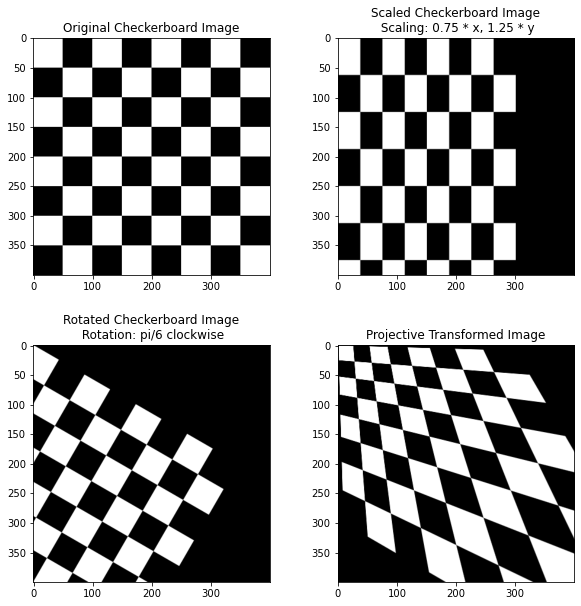

In [8]:
# create checkerboard image

chk_pttn = np.vstack((np.hstack((np.ones((50,50)), np.zeros((50,50)))), np.hstack((np.zeros((50,50)), np.ones((50,50))))))
img_chkrbd = np.tile(chk_pttn, (4, 4))

# generate a scaling affine transformation and warp the checkerboard image
xfm_scl_aff = transform.AffineTransform(scale=[0.75, 1.25])

img_chkrbd_scld = transform.warp(img_chkrbd, xfm_scl_aff.inverse)

# display images
fig_chk, ax_chk = plt.subplots(2, 2, figsize=(10,10))
ax_chk = ax_chk.ravel()

ax_chk[0].imshow(img_chkrbd, cmap='gray')
ax_chk[0].set_title("Original Checkerboard Image")

ax_chk[1].imshow(img_chkrbd_scld, cmap='gray')
ax_chk[1].set_title("Scaled Checkerboard Image\n Scaling: 0.75 * x, 1.25 * y")

# define affine matrix for rotation
xfm_rot_aff = transform.AffineTransform(rotation=np.pi/6)

# apply rotation transformation
img_chkrbd_rot = transform.warp(img_chkrbd, xfm_rot_aff.inverse)

ax_chk[2].imshow(img_chkrbd_rot, cmap='gray')
ax_chk[2].set_title("Rotated Checkerboard Image\n Rotation: pi/6 clockwise")

# projective transformation
xfm_proj_mat = np.array([[0.4788, 0.0135, 0.5059],[0.0135, 0.4788, 0.5059],[-0.0009, -0.0009, 1.000]])

xfm_proj = transform.ProjectiveTransform(matrix=xfm_proj_mat)

# apply projective transformation
img_chkrbd_proj = transform.warp(img_chkrbd, xfm_proj.inverse)

ax_chk[3].imshow(img_chkrbd_proj, cmap='gray')
ax_chk[3].set_title("Projective Transformed Image")

fig_chk.subplots_adjust(hspace=0.3)

**Comparing Interpolation Methods**

I will be using the scipy ndimage package for this example since I want to be able to transform an image without
cropping the output

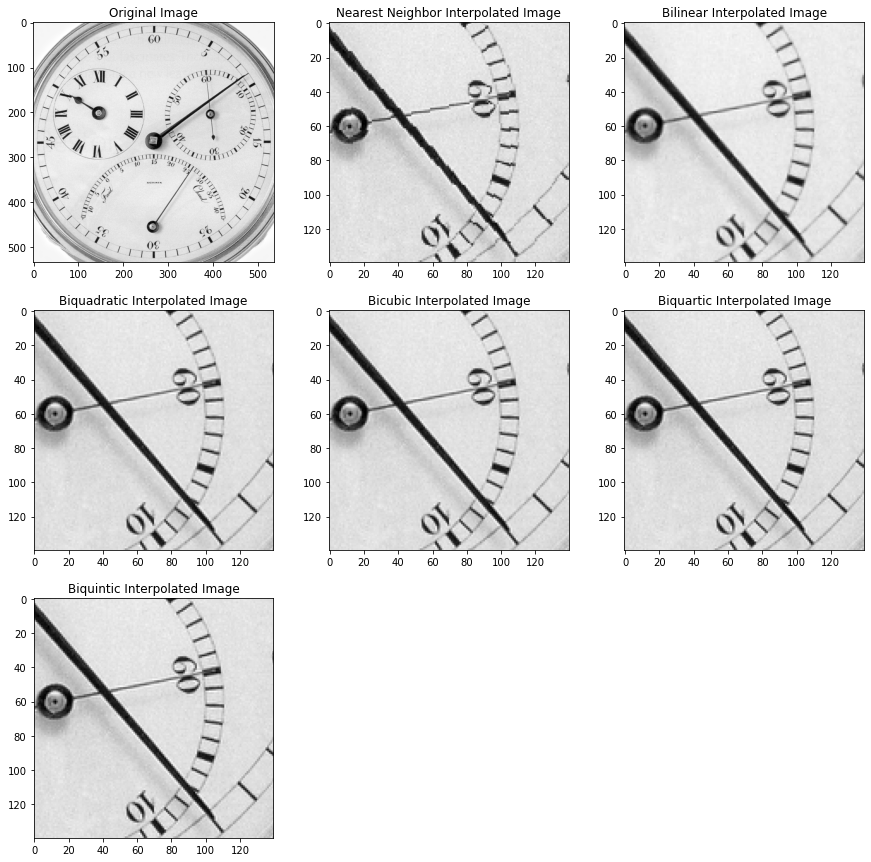

In [9]:
from scipy.ndimage.interpolation import rotate

# load chronometer image
img_chro = io.imread('./images/chronometer-small.tif')

# display image
fig_chro, ax_chro = plt.subplots(3, 3, figsize=(15,15))
ax_chro = ax_chro.ravel()

ax_chro[0].imshow(img_chro, cmap='gray')
ax_chro[0].set_title("Original Image");

# create rotation transformation
#xfm_rot_scl_aff = transform.AffineTransform(rotation=((85.)*(np.pi/180)), scale=1.75)

# apply transform using nearest neighbor interpolation --> interpolation order 0
img_chr_near_neig = rotate(img_chro, angle=-85. , order=0, reshape=True)

# display transformed image
ax_chro[1].imshow(img_chr_near_neig[350:490, 350:490], cmap='gray')
ax_chro[1].set_title("Nearest Neighbor Interpolated Image");

# apply transform using bilinear interpolation
img_chr_bilin = rotate(img_chro, angle=-85. , order=1, reshape=True)

# display transformed image
ax_chro[2].imshow(img_chr_bilin[350:490, 350:490], cmap='gray')
ax_chro[2].set_title("Bilinear Interpolated Image");

# apply transform using biquadratic interpolation
img_chr_biquad = rotate(img_chro, angle=-85. , order=2, reshape=True)

# display transformed image
ax_chro[3].imshow(img_chr_biquad[350:490, 350:490], cmap='gray')
ax_chro[3].set_title("Biquadratic Interpolated Image");


# apply transform using bicubic interpolation
img_chr_bicubic = rotate(img_chro, angle=-85. , order=3, reshape=True)

# display transformed image
ax_chro[4].imshow(img_chr_bicubic[350:490, 350:490], cmap='gray')
ax_chro[4].set_title("Bicubic Interpolated Image");

# apply transform using bicubic interpolation
img_chr_biquartic = rotate(img_chro, angle=-85. , order=4, reshape=True)

# display transformed image
ax_chro[5].imshow(img_chr_biquartic[350:490, 350:490], cmap='gray')
ax_chro[5].set_title("Biquartic Interpolated Image");


# apply transform using bicubic interpolation
img_chr_biquintic = rotate(img_chro, angle=-85. , order=5, reshape=True)

# display transformed image
ax_chro[6].imshow(img_chr_biquintic[350:490, 350:490], cmap='gray')
ax_chro[6].set_title("Biquintic Interpolated Image");

fig_chro.delaxes(ax_chro[7])
fig_chro.delaxes(ax_chro[8])

From the results shown above, the results obtained using bicubic interpolation or higher orders (e.g., bi-quartic or
bi-quintic) yield sharper results than lower order interpolation methods. Moreover, we note that higher order
interpolation methods yield higher contrast images which are more visually appealing.

**Plotting pixel profiles for the different interpolation methods**

Next, we analyze a pixel profile along the red line superimposed on the image below.

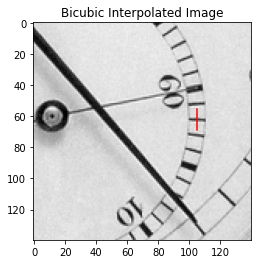

In [10]:
plt.figure()
plt.imshow(img_chr_bicubic[350:490, 350:490], cmap='gray')
plt.plot(np.repeat([105], 15), np.arange(55,70),  'r')
plt.title("Bicubic Interpolated Image");


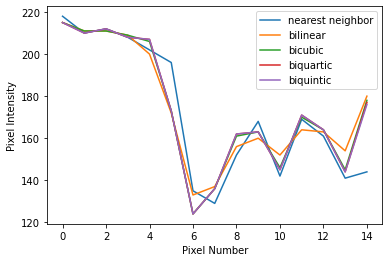

In [11]:
cropped = img_chr_bicubic[55:70, 105].reshape(-1,1)
fig_pix, ax_pix = plt.subplots(1,1)
ax_pix.plot(img_chr_near_neig[55:70, 105].reshape(-1,1),label='nearest neighbor')
ax_pix.plot(img_chr_bilin[55:70, 105].reshape(-1,1),label='bilinear')
ax_pix.plot(img_chr_bicubic[55:70, 105].reshape(-1,1),label='bicubic')
ax_pix.plot(img_chr_biquartic[55:70, 105].reshape(-1,1),label='biquartic')
ax_pix.plot(img_chr_biquintic[55:70, 105].reshape(-1,1),label='biquintic')
ax_pix.set_xlabel("Pixel Number")
ax_pix.set_ylabel("Pixel Intensity")
ax_pix.legend()

Note from the pixel profile plot shown above that the interpolation methods of order 3 and above tend to overshoot or
undershoot near edges and this accounts for the increased sharpness perceived when interpolating with bicubic or higher
order methods. In contrast, nearest neighbor interpolation and bilinear tend to smooth out edges more. Undershoot in our
image can be seen around pixel location 6.

Moreover, note how the higher order interpolation methods seem to track one another. This is indicative that we may not
gain much by using higher order methods, and in fact, may use more computational resources unnecessarily. Of course, the
results always depend on the problem at hand.

**DIPUM Project 1 - Sierpinski Triangle**

The Sierpinski triangle can be formed using an iterative procedure (Moler [2011]). At each step, the current point,
$(x, y)$, is replaced by:

\begin{equation}
\begin{bmatrix} x & y \end{bmatrix}
\begin{bmatrix}
0.5 & 0\\
0 & 0.5
\end{bmatrix} + \begin{bmatrix} b_1 & b_2 \end{bmatrix}
\end{equation}

Part a - Rewrite the equation shown above with a $3 \times 3$ affine matrix $T$.

\begin{equation}
\begin{bmatrix} x & y & 1 \end{bmatrix}
\begin{bmatrix}
0.5 & 0 & 0\\
0 & 0.5 & 0\\
b_1 & b_2 & 1
\end{bmatrix}
\end{equation}

Part b - make three affine2d objects, A1, A2, A3 using

\begin{equation}
\begin{bmatrix} b_1 & b_2 \end{bmatrix} = \begin{bmatrix} 0 & 0 \end{bmatrix}
\end{equation}

\begin{equation}
\begin{bmatrix} b_1 & b_2 \end{bmatrix} = \begin{bmatrix} 0.5 & 0 \end{bmatrix}
\end{equation}

\begin{equation}
\begin{bmatrix} b_1 & b_2 \end{bmatrix} = \begin{bmatrix} \frac{1}{4} & \frac{\sqrt{3}}{4} \end{bmatrix}
\end{equation}

In [12]:
#creating affine objects
# first, get the affine matrix form right
A = np.array([[0.5, 0., 0.], [0., 0.5, 0.], [0., 0., 1.]])
print(A)

A1 = transform.AffineTransform(np.array([[0.5, 0., 0.], [0., 0.5, 0.], [0., 0., 1.]]));

# textbook has a mistake in specifying the b1 b2 offsets
A2 = transform.AffineTransform(np.array([[0.5, 0., 0.], [0., 0.5, 0.], [0.5, 0., 1.]]));
#A2 = affine2d([0.5 0 0; 0 0.5 0; 0.5 0 1]);

A3 = transform.AffineTransform(np.array([[0.5, 0., 0.], [0., 0.5, 0.], [1./4, np.sqrt(3)/4, 1.]]));
#A3 = affine2d([0.5 0 0; 0 0.5 0; 1/4 sqrt(3)/4 1]);


[[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]


part c - generate 100,000 points of the Sierpinski triangle using this
iterative procedure

1. Initialize xy to [0 0]
2. Repeatedly generate the next point using the code
xy(end+1,:) = transformPointsForward(A,xy(end,:)), where A is random is
randomly selected from the three affine2d objects constructed in part (b)

In [13]:
#initialize xy
num_iter = 100000
xy = np.zeros((num_iter, 2), dtype=np.float)

# iterate
for i in range(1,num_iter):
    # select affine object at random

    rand_int = np.random.randint(low=1, high=4, size=(1,1))

    if rand_int == 1:
        A = A1
    elif rand_int == 2:
        A = A2
    elif rand_int == 3:
        A = A3
    else:
        raise Exception('Not a valid affine2d object')

    xy[i,:] = transform.matrix_transform(xy[i-1,:], A.params.T)


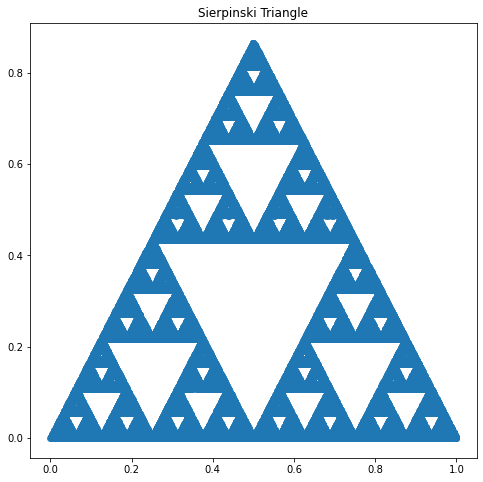

In [14]:
# Plot the Sierpinski triangle
fig_sierp, ax_sierp = plt.subplots(1, 1, figsize=(8,8))
ax_sierp.plot(xy[:,0], xy[:,1],'o', alpha=0.8);
ax_sierp.set_title("Sierpinski Triangle");

**DIPUM Project 4 - Sierpinski Triangle**

This project explores compositions of affine transforms and implementing rotation as three successive shearing
operations: a horizontal shear, followed by a vertical shear, followed by another horizontal shear. This can sometimes
be of practical interest because each shearing operation can be implemented by shifting and interpolating image pixels
in only one direction. For a rotation angle of $\theta$, the three affine shear matrices are:

\begin{equation}
T_1 = \left[\matrix{ 1 & 0 & 0 \cr \alpha & 1 & 0 \cr 0 & 0 & 1} \right]
\end{equation}

\begin{equation}
T_2 = \left[\matrix{ 1 & \beta & 0 \cr 0 & 1 & 0 \cr 0 & 0 & 1} \right]
\end{equation}

\begin{equation}
T_3 = \left[\matrix{ 1 & 0 & 0 \cr \gamma & 1 & 0 \cr 0 & 0 & 1} \right]
\end{equation}

where $\alpha = \gamma = -tan(\theta/2)$ and $\beta = sin(\theta)$

Part a

Make a 4 x 2 matrix containing the four vertices, (0.5, 0.5), (-0.5, 0.5), (-0.5, -0.5), and (-0.5, -0.5), of a unit
square centered at the origin. Plot the square containing these vertices.

Part b

Make three affine2d objects using the three affine transform matrixes shown aboe and $\theta = 70^{\circ}$. In three
steps, apply these affine transforms successively to the vertices of the square and superimpose plots

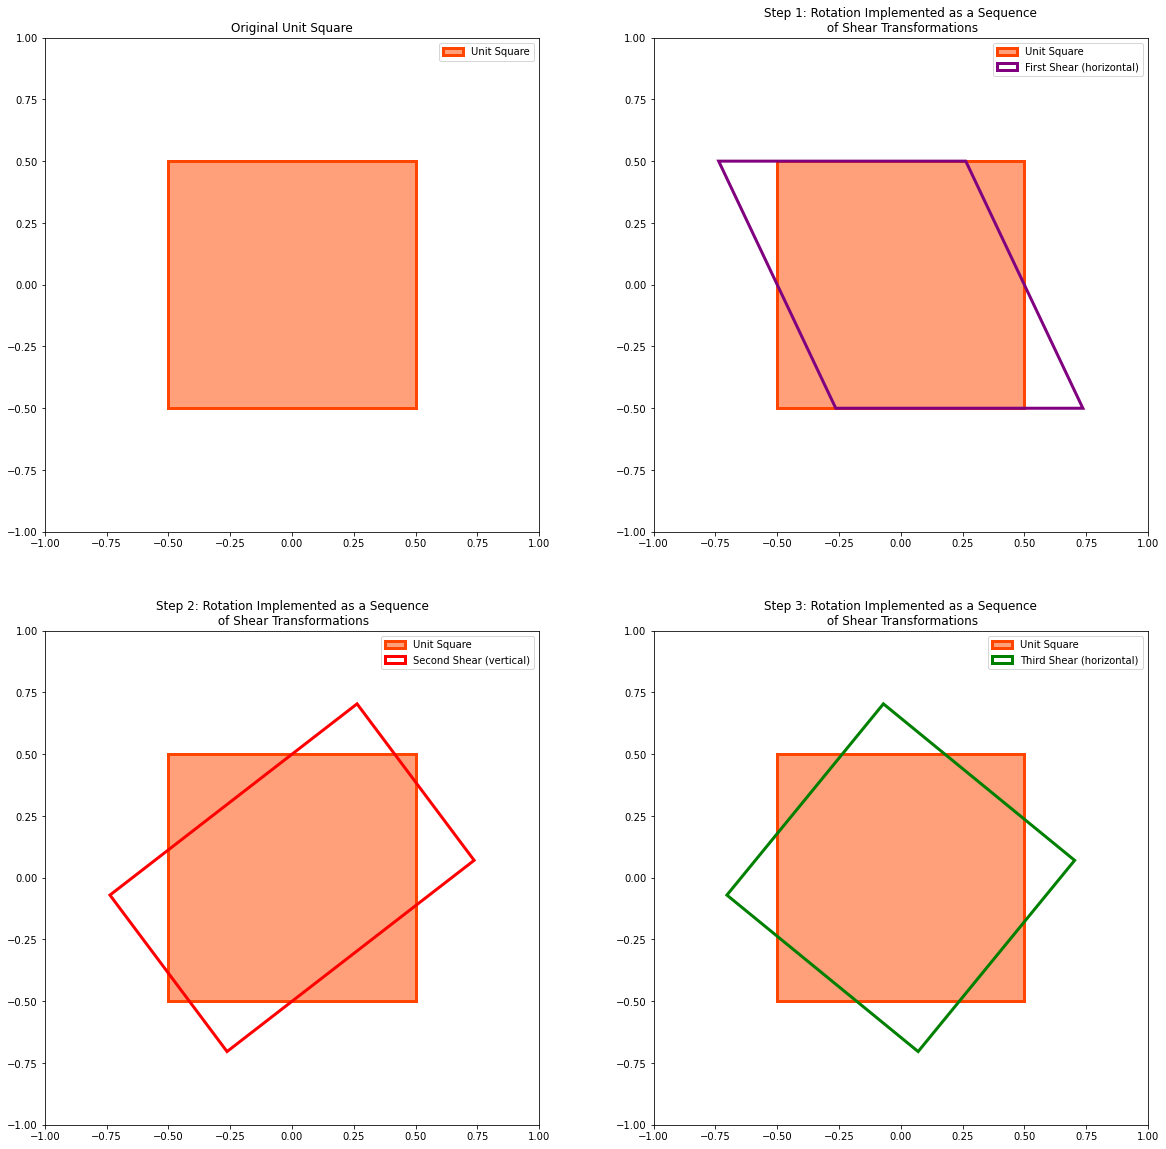

In [17]:
# part a
unit_square = np.array([[0.5, 0.5], [-0.5, 0.5], [ -0.5, -0.5], [0.5, -0.5], [0.5, 0.5]])

# part b
theta = 70;

# first shear - horizontal
xfm_shear_1 = transform.AffineTransform(np.array([[1, 0, 0], [-np.tan(theta/2), 1, 0], [0, 0, 1]], dtype=np.float).T);

# apply transformation to vertices of unit square
unit_square_xfm_1 = transform.matrix_transform(unit_square, xfm_shear_1.params);

# second shear - vertical
xfm_shear_2 = transform.AffineTransform(np.array([[1, np.sin(theta), 0], [0, 1, 0], [0, 0, 1]], dtype=np.float).T);

# apply transformation to vertices of unit square
unit_square_xfm_2 = transform.matrix_transform(unit_square_xfm_1, xfm_shear_2.params);

# third shear - horizontal
xfm_shear_3 = transform.AffineTransform(np.array([[1, 0, 0], [-np.tan(theta/2), 1, 0], [0, 0, 1]], dtype=np.float).T);

# apply transformation to vertices of unit square
unit_square_xfm_3 = transform.matrix_transform(unit_square_xfm_2, xfm_shear_3.params);

#plot the unit square
fig_unit_sq, ax_unit_sq = plt.subplots(2,2, figsize=(20,20), subplot_kw={'aspect': 'equal'})
ax_unit_sq = ax_unit_sq.ravel()

ax_unit_sq[0].set(xlim=[-1., 1.], ylim=[-1., 1.])
ax_unit_sq[1].set(xlim=[-1., 1.], ylim=[-1., 1.])
ax_unit_sq[2].set(xlim=[-1., 1.], ylim=[-1., 1.])
ax_unit_sq[3].set(xlim=[-1., 1.], ylim=[-1., 1.])

ax_unit_sq[0].fill(unit_square[:,0], unit_square[:,1], facecolor='lightsalmon', edgecolor='orangered',
                linewidth=3, label="Unit Square")

# plot the first shear
ax_unit_sq[1].fill(unit_square[:,0], unit_square[:,1], facecolor='lightsalmon', edgecolor='orangered',
                linewidth=3, label="Unit Square")

ax_unit_sq[1].fill(unit_square_xfm_1[:,0], unit_square_xfm_1[:,1], facecolor='none', edgecolor='purple',
                linewidth=3, label="First Shear (horizontal)")

# plot the second shear
ax_unit_sq[2].fill(unit_square[:,0], unit_square[:,1], facecolor='lightsalmon', edgecolor='orangered',
                linewidth=3, label="Unit Square")

ax_unit_sq[2].fill(unit_square_xfm_2[:,0], unit_square_xfm_2[:,1], facecolor='none', edgecolor='red',
                linewidth=3, label="Second Shear (vertical)")

# plot the first shear
ax_unit_sq[3].fill(unit_square[:,0], unit_square[:,1], facecolor='lightsalmon', edgecolor='orangered',
                linewidth=3, label="Unit Square")

ax_unit_sq[3].fill(unit_square_xfm_3[:,0], unit_square_xfm_3[:,1], facecolor='none', edgecolor='green',
                linewidth=3, label="Third Shear (horizontal)")

ax_unit_sq[0].legend();
ax_unit_sq[1].legend();
ax_unit_sq[2].legend();
ax_unit_sq[3].legend();

ax_unit_sq[0].set_title("Original Unit Square");
ax_unit_sq[1].set_title("Step 1: Rotation Implemented as a Sequence\n of Shear Transformations");
ax_unit_sq[2].set_title("Step 2: Rotation Implemented as a Sequence\n of Shear Transformations");
ax_unit_sq[3].set_title("Step 3: Rotation Implemented as a Sequence\n of Shear Transformations");


Note how our unit circle has been rotated by $45^\circ$ in the last step of shear transformations.